# JobAgent
--- 

### Table of contents:
1. [Search Tool](#search-tool)
1. [SOTA Transformer](#SOTA-Transformer)
1. [Key Insights](#key-insights)
1. [Schema and agent creation](#schema-and-agent-creation)
1. [Example Report](#example-report)


## JobAgent Overview
JobAgent is a hybrid solution designed to: 1. Create concise company reports by referencing reviews and overviews extracted from a company's about page. 2. Match and score the semantic relationship between a job description and a resume. 3. If a relevant job was found, JobAgent will compose a personalised email or a general email, depending on whether a contact person is identified within the job description. 

### 💡 Motivation
Searching for relevant jobs to apply for can be time-consuming. Candidates typically go through the following steps when exploring a job: 
- Reviewing the qualifications required for the role to evaluate how well they match their resume (i.e., how many qualifications they meet). 
- Reading the role description to determine its relevance to the job they seek.
- Exploring company reviews to assess whether the company is a good place to work.
- Learning about the company's essence or value proposition from the about page. 
- Searching for a contact person within the job description to craft a personalized email, thereby increasing their chances of landing an interview.
JobAgent was developed to save time by streamlining this entire process.

### Key Concepts
1. **Web Search (Reviews & Overviews)**: Asynchronously extracting reviews and overviews from the about page about a company using TavilySearchResults tool using robust prompt descriptions. 
2. **Sentiment Classification**: Conduct sentiment analysis over a **single review** using a siebert/sentiment-roberta-large-english (encoder only model). 
3. **Summaries**: Summarising both the concatinated positive and negative reviews as well as the company overview extracted from the about page.

## JobAgent Overview
JobAgent is a hybrid solution designed to:
1. Create concise company reports by referencing reviews and overviews extracted from a company's about page.
2. Match and score the semantic relationship between a job description and a resume.
3. If a relevant job was found, JobAgent will compose a personalised email or a general email, depending on whether a contact person is identified within the job description.

### 💡 Motivation
Searching for relevant jobs to apply for can be time-consuming. Candidates typically go through the following steps when exploring a job:

- Reviewing the qualifications required for the role to evaluate how well they match their resume (i.e., how many qualifications they meet).
- Reading the role description to determine its relevance to the job they seek.
- Exploring company reviews to assess whether the company is a good place to work.
- Learning about the company's essence or value proposition from the about page.
- Searching for a contact person within the job description to craft a personalized email, thereby increasing their chances of landing an interview.

JobAgent was developed to save time by streamlining this entire process.

### Key Concepts
1. **Web Search (Reviews & Overviews)**: Asynchronously extracting reviews and overviews from the `about page` about a company using `TavilySearchResults` tool using robust prompt descriptions.
2. **Sentiment Classification**: Conduct sentiment analysis over a **single review** using a `siebert/sentiment-roberta-large-english` (encoder only model). 
3. **Summaries**: Summarising both the concatinated positive and negative reviews as well as the company overview extracted from the about page. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import asyncio
import re
from collections import defaultdict
from typing import Annotated, Any, Dict, List
from uuid import uuid4

import nest_asyncio
import torch
from dotenv import load_dotenv
from IPython.display import Image, Markdown, display
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage, SystemMessage
from langchain_core.tools import BaseTool
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from termcolor import colored
from tqdm import trange
from transformers import pipeline
from typing_extensions import TypedDict

load_dotenv()

True

## Search Tool

In [3]:
search_tool_sys_prompt: str = """
# GOAL
Find and extract **recent employee reviews** for a given company, strictly from **Glassdoor** and **Indeed**. Output must provide a balanced view of both positive and negative employee experiences.

# TASK
1. **Review written language**: Only extract reviews written in English!
2. **Search Scope:** You are expected to perform the search and return **the most relevant and recent review content available**. Limit results to review pages on:
  - `https://www.glassdoor.com.au/Reviews/`
  - `https://au.indeed.com/cmp/.../reviews`
3. **Content Retrieval:** 
    - Once a relevant review page is found, extract the review content
    - Extract **employee-written review text only** (not job postings, company descriptions, or ads). 
    - Prefer direct review quotes. If unavailable, provide concise summaries.
4. **Sentiment Analysis (Extracting Positive/Negative):** 
  - Clearly separate **positive points (pros)** and **negative points (cons)**.
  - Highlight if reviewers mention company culture, growth opportunities, pay, or work-life balance.
5. **Recency Priority:**
  - Always favor the **most recent reviews**.
  - If multiple similar reviews exist, prefer the newest and avoid duplicates.
6. **Exclusions:**
   - Discard results that lead to CAPTCHAs, login walls, broken links, or irrelevant content.

# EXAMPLES
Example 1:
{{
  "title": "LeasePLUS Pty Ltd Employee Reviews | Indeed.com",
  "url": "https://au.indeed.com/cmp/Leaseplus-Pty-Ltd/reviews",
  "date": "2014-05-18",
  "pros": "Learned new technologies, approachable team.",
  "cons": "Complicated structure, no career development, politics.",
  "sentiment_score": -0.3,
  "company": "LeasePLUS"
}}

Example 2:
{{
  "title": "LeasePLUS Reviews - Glassdoor",
  "url": "https://www.glassdoor.com.au/Reviews/LeasePLUS-Reviews-E2942949.htm",
  "date": "2021-08-12",
  "pros": "Career growth opportunities, friendly leadership.",
  "cons": "Work-life balance issues, below-market pay.",
  "sentiment_score": 0.1,
  "company": "LeasePLUS"
}}
"""

In [4]:
# Search configurations
N_REVIEWS: int = 10
COMPANIES: List[str] = [
    "LeasePLUS",
    "CarSales",
    "Acenda",
    "iag",
    "Colonial First State Investments",
    "CultureAmp"
]

nest_asyncio.apply()
async def search_reviews(company: str) -> List[Dict[str, Any]]:
    """
    This function will return N_REVIEWS for a single company and add the company name to each result.
    """
    query = f"Provide a review on {company}"
    # Define a search tool 
    search_tool: BaseTool = TavilySearchResults(
        description=search_tool_sys_prompt,
        verbose=True,
        response_format="content_and_artifact",
        max_results=N_REVIEWS,
        search_depth="advanced",
        include_domains=["glassdoor.com.au", "indeed.com"],  
        include_images=False
    )
    # Asnchnously execute the search tool
    outputs = await search_tool.ainvoke(query)
    
    # Add the company name to the resulting output 
    output_with_company = [{**out, "company": company} for out in outputs]
    return sorted(
        output_with_company, reverse=True, key=lambda x: x["score"]
    )

async def search_reviews_all_companies(companies: List[str], batch_size: int = 2) -> List[Dict[str, Any]]:
    """
    Executes a list of companies in batches of 2.
    Returns a flat list of dicts, each with an added 'company' key.
    """
    all_results: List[List[Dict[str, Any]]] = []
    
    for i in trange(0, len(companies), batch_size):
        batch: List[str] = companies[i:i+batch_size]
        print(f"Processing batch {i // batch_size + 1}")
        
        # TaskGroup will await the coroutines for us in the event loop 
        async with asyncio.TaskGroup() as tg: 
            # Create and schedule a task for each query in the batch
            tasks = [tg.create_task(search_reviews(company)) for company in batch]
        
        for task in tasks:
            outputs: List[Dict[str, Any]] = task.result()
            all_results.extend(outputs)
    
    return all_results

In [5]:
# Extract reviews 
company_reviews: List[Dict[str, Any]] = asyncio.run(search_reviews_all_companies(COMPANIES))
company_reviews[:5]

  0%|          | 0/3 [00:00<?, ?it/s]

Processing batch 1
[{'title': '5: carsales.com.au Employee Reviews', 'url': 'https://au.indeed.com/cmp/Carsales.com.au/reviews', 'content': 'Very fun and laid back culture. Though with that said, it is amazing to work with so many people who are dedicated and passionate about their work. It is', 'score': 0.5677694}, {'title': 'carsales Reviews', 'url': 'http://www.glassdoor.com.au/Reviews/carsales-com-au-Reviews-E657475.htm', 'content': "# Help Us Protect Glassdoor\n\nPlease help us protect Glassdoor by verifying that you're a\nreal person. We are sorry for the inconvenience. If you continue to see this\nmessage, please email\nto let us know you're having trouble.\n\n# Aidez-nous à protéger Glassdoor\n\nAidez-nous à protéger Glassdoor en confirmant que vous êtes une personne réelle.\nNous sommes désolés pour la gêne occasionnée. Si vous continuez à voir ce\nmessage, contactez-nous à l'adresse\npour nous faire part du problème. [...] Ayúdanos a proteger Glassdoor verificando que eres un

 33%|███▎      | 1/3 [00:02<00:05,  2.88s/it]

[{'title': '5: LeasePLUS Pty Ltd Employee Reviews', 'url': 'https://au.indeed.com/cmp/Leaseplus-Pty-Ltd/reviews', 'content': "Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros\n---- Nothing to say  Cons\n---- No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more        Report Review Copy link          \n     18 May 2014 ### Productive and overall a good place to work\n\nDeveloper [...] Image 10 Bupa ---- 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare\n\nslide 10 of 10\n\nImage 11 Australia Post -------------- 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare\n\n1 / 4 1 / 4\n\n#### Questions about Leas

 67%|██████▋   | 2/3 [00:06<00:03,  3.22s/it]

[{'title': 'Working at Acenda Integrated Health: Employee Reviews', 'url': 'https://www.indeed.com/cmp/Acenda-Integrated-Health/reviews?ftext=company', 'content': "The company has horrible growth opportunities, they don't truly acknowledge employees with great work ethics. You can work hard and the work will go unnoticed.", 'score': 0.644248}, {'title': 'Working at Acenda Integrated Health in Glassboro, NJ: 52 Reviews', 'url': 'https://www.indeed.com/cmp/Acenda-Integrated-Health/reviews?fcountry=US&floc=Glassboro%2C+NJ', 'content': "Jun 14, 2025 · This is the most fair and professional human service agency I've ever worked. They do strive to be financially fair to their employees and offer growth", 'score': 0.6364215}, {'title': 'Working at Acenda Integrated Health: 108 Reviews', 'url': 'https://www.indeed.com/cmp/Acenda-Integrated-Health/reviews?start=20', 'content': 'Therapist\n   Case Manager\n   Counselor\n   Residential Counselor\n   Coach\n\nSee all job titles at Acenda Integrate

100%|██████████| 3/3 [00:08<00:00,  2.87s/it]

[{'title': 'Colonial First State "team" Reviews | Glassdoor', 'url': 'https://www.glassdoor.com.au/Reviews/Colonial-First-State-team-Reviews-EI_IE936718.0,20_KH21,25.htm', 'content': 'Employees also rated Colonial First State 3.4 out of 5 for work life balance, 3.2 for culture and values and 3.2 for career opportunities.', 'score': 0.7099254}, {'title': '20: Colonial First State Employee Reviews', 'url': 'https://au.indeed.com/cmp/Colonial-First-State/reviews', 'content': 'CFS is under Commonwealth bank, which is rated the best employer of banking. The employee benefit is very good as shares and study support are provided. Pros.', 'score': 0.60358196}, {'title': 'What Is It Like to Work At Colonial First State? - Reviews', 'url': 'https://www.glassdoor.com.au/Reviews/Colonial-First-State-Reviews-E936718.htm', 'content': '63% of Colonial First State employees would recommend working there to a friend based on Glassdoor reviews. Employees also rated Colonial First State 3.5 out of', 'sco

[{'title': '5: LeasePLUS Pty Ltd Employee Reviews',
  'url': 'https://au.indeed.com/cmp/Leaseplus-Pty-Ltd/reviews',
  'content': "Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros\n---- Nothing to say  Cons\n---- No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more        Report Review Copy link          \n     18 May 2014 ### Productive and overall a good place to work\n\nDeveloper [...] Image 10 Bupa ---- 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare\n\nslide 10 of 10\n\nImage 11 Australia Post -------------- 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare\n\n1 / 4 1 / 4\n\n#### Questions about 

In [9]:
def filter_and_format_reviews(obj: List[Dict[str, Any]]) -> List[Dict[str, Any]]: 
    """
    Filter a list of review objects to include only those whose 'url' field 
    contains the substring 'review' (case-insensitive).

    :param obj: A list of dictionaries, each expected to have a 'url' key.
    :type obj: List[Dict[str, Any]]
    :return: A filtered list containing only dictionaries where the 'url' includes 'review'.
    :rtype: List[Dict[str, Any]]
    """
    # Filter reviews 
    filtered_reviews: List[Dict[str, Any]] = [
        review for review in obj 
        if re.search("review", review["url"], flags=re.IGNORECASE)
    ]
    # Clean the 'content' field of each filtered review
    for rev in filtered_reviews:
        if "content" in rev and isinstance(rev["content"], str):
            rev["content"] = re.sub(
                pattern=r"[\s\-]+|\[.*?\]|#",
                repl=" ",
                string=rev["content"]
            ).strip()

    return filtered_reviews

filtered_reviews = filter_and_format_reviews(company_reviews)
filtered_reviews[:5]

[{'title': '5: LeasePLUS Pty Ltd Employee Reviews',
  'url': 'https://au.indeed.com/cmp/Leaseplus-Pty-Ltd/reviews',
  'content': "Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros Nothing to say Cons No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more Report Review Copy link 18 May 2014     Productive and overall a good place to work Developer   Image 10 Bupa 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare slide 10 of 10 Image 11 Australia Post 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare 1 / 4 1 / 4      Questions about LeasePLUS Pty Ltd   South Melbourne The work routine starts with morning st

## SOTA Transformer
---

### Semantic Analysis with Transformer 

In [10]:
sentiment_analyser = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english", device="cpu")

# Define a function to apply sentiment analysis
def analyse_company_sentiments(obj: List[Dict[str, Any]], batch_size: int = 10) -> List[Dict[str, Any]]:
    """
    Apply sentiment analysis to a list of review objects and enrich each object with 'score' and 'label'.

    :param obj: A list of dictionaries, each expected to have a 'content' key.
    :param batch_size: The number of reviews to process in each batch.
    :return: A list of dictionaries with added 'score' and 'label' from sentiment analysis.
    """
    # Extract content for sentiment-analysis from object
    review_contents = [review["content"] for review in obj]
    
    all_results = []
    # torch.set_num_threads() should be set once, not in a loop
    torch.set_num_threads(2)

    # Process the texts in batches
    for i in trange(0, len(review_contents), batch_size):
        batch_text = review_contents[i:i + batch_size]
        batch_obj = obj[i:i+batch_size]
        with torch.no_grad():
            analysis_results = sentiment_analyser(batch_text)
            
            # Enrich object with sentiment score and label
            batch_obj_with_sentiment = [
                {**review, "score": result["score"], "label": result["label"]}
                for review, result in zip(batch_obj, analysis_results)
            ]
            all_results.extend(batch_obj_with_sentiment)

    return all_results

reviews_with_sentiment: List[Dict[str, Any]] = analyse_company_sentiments(filtered_reviews)
reviews_with_sentiment[:3]

Device set to use cpu
100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


[{'title': '5: LeasePLUS Pty Ltd Employee Reviews',
  'url': 'https://au.indeed.com/cmp/Leaseplus-Pty-Ltd/reviews',
  'content': "Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros Nothing to say Cons No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more Report Review Copy link 18 May 2014     Productive and overall a good place to work Developer   Image 10 Bupa 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare slide 10 of 10 Image 11 Australia Post 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare 1 / 4 1 / 4      Questions about LeasePLUS Pty Ltd   South Melbourne The work routine starts with morning st

In [11]:
top_n = 5
# Create a defaultdict with list as default factory
company_groups = defaultdict(list)
for review in reviews_with_sentiment:
    company = review.get("company")
    if len(company_groups[company]) < top_n:
        company_groups[company].append(review) # only append a review if the size if less then top_n
# Flatten sample reviews
sample_reviews = [rev for revs in company_groups.values() for rev in revs]

for i, review in enumerate(sample_reviews, start=1):
    # Extract attributes from reviews
    sentiment_label = review.get("label")
    company = review.get("company")
    title = review.get("title")
    content = review.get("content")
    score = review.get("score")

    # Color the sentiment 
    color = "green" if sentiment_label == "POSITIVE" else "red"
    colored_sentiment = colored(f"Sentiment Label: {sentiment_label}", color)

    # Print result summary
    print(f"""
Sample number {i} (company: {company})=> 
Title: {title} | Content: {content} 
Sentiment Label: {colored_sentiment} | Sentiment Score: {score} 
""", end="-"*100 + "\n")


Sample number 1 (company: LeasePLUS)=> 
Title: 5: LeasePLUS Pty Ltd Employee Reviews | Content: Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros Nothing to say Cons No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more Report Review Copy link 18 May 2014     Productive and overall a good place to work Developer   Image 10 Bupa 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare slide 10 of 10 Image 11 Australia Post 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare 1 / 4 1 / 4      Questions about LeasePLUS Pty Ltd   South Melbourne The work routine starts with morning stand up meeting where all the team

### Summarising & Exploring Sentiments

In [13]:
def create_positive_negative_reviews_dict(reviews: List[Dict[str, Any]], company: str) -> Dict[str, Dict[str, List[str]]]:
    """
    Aggregates positive and negative reviews for a single company group.

    :param reviews: List of review dictionaries with 'label', 'company', and 'content' keys.
    :param company: The company name to filter reviews for.
    :return: A dictionary with the company name as key, containing 'POSITIVE' and 'NEGATIVE' lists.
    """
    pos_content: List[str] = []
    neg_content: List[str] = []

    for review in reviews:
        if review.get("company") != company:
            continue  # Skip reviews from other companies

        content = review.get("content", "")
        label = review.get("label")

        if label == "POSITIVE":
            pos_content.append(content)
        elif label == "NEGATIVE":
            neg_content.append(content)

    return {
        company: {
            "POSITIVE": pos_content,
            "NEGATIVE": neg_content
        }
    }


pos_neg_companies_reviews: List[Dict[str, Dict[str, List[str]]]] = [
    create_positive_negative_reviews_dict(reviews_with_sentiment, company)
    for company in COMPANIES
]
pos_neg_companies_reviews[:2]

[{'LeasePLUS': {'POSITIVE': ["Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros Nothing to say Cons No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more Report Review Copy link 18 May 2014     Productive and overall a good place to work Developer   Image 10 Bupa 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare slide 10 of 10 Image 11 Australia Post 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare 1 / 4 1 / 4      Questions about LeasePLUS Pty Ltd   South Melbourne The work routine starts with morning stand up meeting where all the team members give their updates about previous day's work and the thing

In [14]:
# Exploring how many negatives and positives instances appear for each company
for review in pos_neg_companies_reviews:
    for company in COMPANIES:
        if review.get(company) is not None: 
            overall_reviews = len(review.get(company).get("POSITIVE")) + len(review.get(company).get("NEGATIVE"))
            overall_pos_reviews = len(review.get(company).get("POSITIVE"))
            overall_neg_reviews = len(review.get(company).get("NEGATIVE"))
            print(f"COMPANY: {company}")
            print(f"Overall REVIEWS: {overall_reviews}")
            print(f"Overall NEGATIVE REVIEWS: {overall_neg_reviews}")
            print(f"Overall POSITIVE REVIEWS: {overall_pos_reviews}")
            print("-"*100)

COMPANY: LeasePLUS
Overall REVIEWS: 8
Overall NEGATIVE REVIEWS: 6
Overall POSITIVE REVIEWS: 2
----------------------------------------------------------------------------------------------------
COMPANY: CarSales
Overall REVIEWS: 9
Overall NEGATIVE REVIEWS: 8
Overall POSITIVE REVIEWS: 1
----------------------------------------------------------------------------------------------------
COMPANY: Acenda
Overall REVIEWS: 7
Overall NEGATIVE REVIEWS: 6
Overall POSITIVE REVIEWS: 1
----------------------------------------------------------------------------------------------------
COMPANY: iag
Overall REVIEWS: 7
Overall NEGATIVE REVIEWS: 4
Overall POSITIVE REVIEWS: 3
----------------------------------------------------------------------------------------------------
COMPANY: Colonial First State Investments
Overall REVIEWS: 5
Overall NEGATIVE REVIEWS: 3
Overall POSITIVE REVIEWS: 2
----------------------------------------------------------------------------------------------------
COMPANY: Cul

In [15]:
# Create a function to concatenate Positive and negative reviews
def concatenate_reviews(obj: List[Dict[str, Dict[str, List[str]]]], company: str) -> Dict[str, Dict[str, str]]: 
    results = {}
    for review in obj: 
        company_review = review.get(company)
        if company_review is not None: 
            concatenated_pos_reviews = "\n".join([f"{i}. {rev}" for i, rev in enumerate(company_review.get("POSITIVE"), start=1)])
            concatenated_neg_reviews = "\n".join([f"{i}. {rev}" for i, rev in enumerate(company_review.get("NEGATIVE"), start=1)])
            results[company] = {"POSITIVE": concatenated_pos_reviews, "NEGATIVE": concatenated_neg_reviews}
    
    return results

concatenated_reviews = [
    concatenate_reviews(pos_neg_companies_reviews, company=company)
    for company in COMPANIES
]
concatenated_reviews

[{'LeasePLUS': {'POSITIVE': "1. Company structure is very complected. Too much of double work which takes lot of time and make the work flow complected. Pros Nothing to say Cons No opportunity to grow, No career development programs provided, Single person controls everything & too much of politics...Show more Report Review Copy link 18 May 2014     Productive and overall a good place to work Developer   Image 10 Bupa 3.3 3.4K reviews At Bupa, we want lives to be happier and healthier, and there are many ways that we can make a positive difference. That’s why we’ve been busyCompare slide 10 of 10 Image 11 Australia Post 3.7 1.2K reviews We connect people with each other and the world. We help unlock opportunities for everyone. We’re proud to be one of Australia’s most diverseCompare 1 / 4 1 / 4      Questions about LeasePLUS Pty Ltd   South Melbourne The work routine starts with morning stand up meeting where all the team members give their updates about previous day's work and the thi

In [ ]:
SENTIMENT_SUMMARY_SYS_PROMPT: str = """
<|im_start|>system
Your task is to analyze and summarize employee reviews (positive and negative) to provide a balanced overview of a company's:
- Culture
- Work-life balance
- Growth and career opportunities

# INSTRUCTIONS
- Review both positive and negative feedback.
- Extract recurring themes, strengths, and concerns.
- Exclude reviews if they are not written in English.
- Write in a clear, neutral, and professional tone.
- Balance positives and negatives to avoid bias.
- Organize the summary into three sections: Culture, Work-life balance, Growth opportunities.
- Keep each section concise (3–5 sentences).

# OUTPUT FORMAT
* **Culture**:
  [summary here]

* **Work-life balance**:
  [summary here]

* **Growth opportunities**:
  [summary here]

NOTE: The summary text must be indented to align with the "[summary here]" placeholder, as shown in the example above. It must NOT start a new line directly after the colon.

# Positive Reviews for {company}
{pos_rev}

# Negative Reviews for company {company}
{neg_rev}
<|im_end|>
"""

### Extract company overview:

In [21]:
# Company reviews 
SEARCH_TOOL_COMPANY_WEBSITE: str = """
# TASK
You are tasked with extracting information from the official "About" page of a company. 

# CONSTRAINS & INSTRUCTIONS
- **Geography**: Only return results from Australian 
s (e.g., .com.au, .org.au, .gov.au).
- **URLs**: Only return valid URL from a secured source (HTTPS).
- **Content returned**: 
    - Do not fabricate or infer details not explicitly provided on the page. 
    - If multiple versions of the "About" section are found, prefer the official corporate website.  
- **Exclusions**: Ignore ads, navigation menus, unrelated links, images, or generic content. 
"""

nest_asyncio.apply()
async def get_company_overview(company: str) -> Dict[str, Any]: 
    """
    Fetches, cleans, and formats a company's "About Us" page content.
    (This is the helper function you refined in the previous turns)
    """

    QUERY: str = "site: https://{company} about us page"
    search_tool: BaseTool = TavilySearchResults(
        description=SEARCH_TOOL_COMPANY_WEBSITE,
        verbose=True,
        response_format="content_and_artifact",
        max_results=2,
        search_depth="advanced",
        include_domains=["*.com.au", "*.com", ".gov.au"],  
        include_images=False,
        include_raw_content=True,
    )
    results = await search_tool.ainvoke(QUERY.format(company=company))
    
    for result in results:
        
        url: str = result.get("url")
        title: str = result.get("title")
        content: str = result.get("raw_content") or result.get("content")
        if content:
            # Remove content within brackets and parenthese
            content_formatted = re.sub(r"\[.*?\]|\(.*?\)", "", content) 

            # Replace multiple spaces, pipes, exclamation marks, and asterisks with a single space
            content_formatted = re.sub(r"[\s\|\!\*:\)\(,\-—=]+", " ", content_formatted) 

            # Clean up any leading/trailing whitespace
            content_formatted = content_formatted.strip(r":)(]-").strip() 

            overview_formatted: str = "#" + title + ":\n" + content_formatted
            return {
                "url": url,
                "content": overview_formatted,
                "company": company
            }
        
    return {
        "url": None,
        "content": "No relevant 'About Us' content found.",
        "company": company
    }


async def get_all_companies_overview(companies: List[str]) -> List[Dict[str, Any]]: 
    """
    A tool to concurrently extract the "About Us" page overview 
    for a list of companies.
    """
    all_results: List[Dict[str, Any]] = []
    
    async with asyncio.TaskGroup() as tg: 
        tasks = [tg.create_task(get_company_overview(company=company)) for company in companies]
    
    for task in tasks: 
        results: List[Dict[str, Any]] = task.result()
        all_results.append(results)
    return all_results

example_overviews = asyncio.run(get_all_companies_overview(companies=COMPANIES))
example_overviews[:2]

[{'title': 'About Us | IAG', 'url': 'https://www.iairgroup.com/about-us/', 'content': 'Close search form\n\nSearch for Submit search\n\nToggle mobile navigation\n\nAbout us\n\nConnected by our purpose\n\n   Home\n   About us\n\nOur purpose\n\nAt IAG, our purpose is to connect people, businesses and countries using aviation as a force for good.\n\nWe believe in the transformative power of flight: enabling personal and professional connections, supporting global trade and fostering the discovery of new places, ideas and experiences. [...] About Us | IAG – International Airlines Group\n\nYour choice regarding cookies on this site\n\nWe use cookies to optimise site functionality and give you the best possible experience.\n\nAccept All Reject All Customise settings\n\nPress Option+1 for screen-reader mode, Option+0 to cancelAccessibility Screen-Reader Guide, Feedback, and Issue Reporting | New window\n\nLSE:389.70 GBP MAD:4.51 EUR\n\nEN/ES\n\nOpen search form\n\nClose search form\n\nSearch 

[{'url': 'https://ca.linkedin.com/company/lease-plus-financial',
  'content': "#Lease Plus Financial:\n# Lease Plus Financial Add More Possibility Financial Services • Calgary Alberta • 146 followers • 2 10 employees ## Overview Lease Plus Financial™ is a subsidiary of Credicor Financial Corp. a 100% Canadian owned Calgary based leasing and financing company catering to businesses and individuals. Lease Plus breaks down the barriers to connect you or your clients with the financing you need. Our tight knit crew of experienced leasing professionals work harder and smarter to deliver the best and most diverse business solutions. As a second generation family run unit we understand the challenges of small business. We know quick access to financing is about more than just equipment it’s a step towards your freedom. We’re more than 25 years into the game but we refuse to be tied by convention. With astute expertise dogged determination and access to large capital we merge our areas of spec

In [22]:
COMPANY_OVERVIEW_SYS_PROMPT: str = """
<|im_start|>system

# TASK: 
You are an expert business analyst and technical writer. Your task is to provide a concise, holistic overview of a company based on the provided "About Us" page text.

Your summary must adhere to the following rules:
1. **Structure:** The output should be a single, cohesive paragraph.
2. **Length:** The summary must be between 100-150 words. Do not exceed 150 words. If the source text is too short to reach 100 words, focus on clarity and completeness without adding filler.
3. **Content Focus:**
    * Identify and articulate the company's core **areas of focus** or what they do.
    * Clearly state the company's **vision, mission, or purpose**. This includes what they are trying to achieve or what problem they aim to solve.
    * Only use information explicitly mentioned in the provided text. Do not make assumptions or infer new information.
4. **Tone:** Use a natural, straightforward tone that is easy to read. Avoid overly formal, promotional, or marketing-style language.
5. **Format:** No headings, bullet points, or lists. The final output must be a single block of text.
6. **Style:** Avoid repetition or rephrasing of the same idea.

Below is the "About Us" page text: 
{about_us}
<|im_end|>
"""

---
## Schema and agent creation

In [23]:
# Define LLM
llm = ChatOllama(
    model="qwen2.5",
    temperature=0
)

######################################
# <<<< State Definitions: Main >>>>
######################################

class ConversationState(TypedDict):
    """Represents the state of our conversation."""
    messages: Annotated[List[AnyMessage], add_messages] 
    name: str
    companies: List[str]
    sentiment_summaries: List[str]
    overview_summaries: List[str]
    final_report: str 


######################################
# <<<< Structured Outputs States >>>>
######################################

class UserInfo(BaseModel):
    "A model to collect information from a user"
    name: str = Field(description="The name of the user.")
    companies: List[str] = Field(description="A list containing the companies to conduct a research on")
    user_id: str = Field(
        description="Unique identifier of the user",
        default=f"USER-{uuid4()}"
    )

class SentimentSummary(BaseModel):
    "Sentiment and company overview summaries"
    companies: List[str] = Field(
        description="A list containing the companies names"
    )
    positive_reviews: List[str] = Field(
        description="A list containing positive reviews about a companies"
    )
    negative_reviews: List[str] = Field(
        description="A list containing negative reviews about a companies"
    )

class CompaniesOverview(BaseModel):
    companies: List[str] = Field(description="A list containing the companies names")
    urls: List[str] = Field(description="A list containing valid URL of company")
    companies_overview: List[str] = Field(description="A list containing a summary containing an overview for each of the companies")

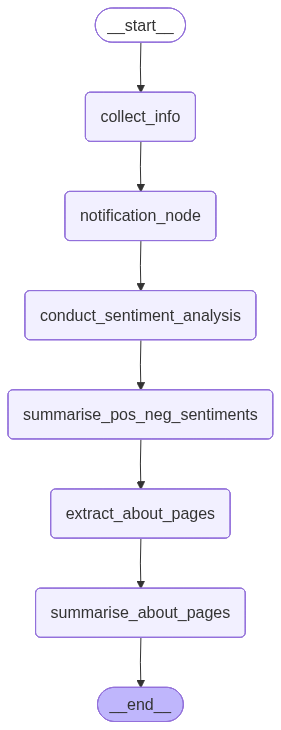

In [24]:
# Define Nodes

######################################
# <<<< OPENNING Nodes >>>>
######################################
def get_initial_greeting() -> AIMessage:
    """Initial message to the user."""
    return AIMessage(content="Hi, I am your assistant, can you please tell me your name and preferences?")

def collect_info_node(state: ConversationState) -> Dict[str, Any]:
    """Use LLM to extract name and preferences from the user’s reply."""
    
    # We pass the entire message history to the LLM for full context.
    message = state["messages"]
    
    sys_message = """
    You are a helpful assistant with high attention to detail.
    #TASK
    Extract the user's name and preferences from the conversation history.
    """
    
    # To envoke the Agent we will use the SystemMessage with a HumanMessage
    response = llm.with_structured_output(UserInfo).invoke([SystemMessage(content=sys_message)] + message)

    return {"name": response.name, "companies": response.companies}  

def notification_node(state: ConversationState) -> Dict[str, List[str]]:
    """Constructs and sends the final confirmation message."""
    final_message = f"Thanks {state["name"]}! I've saved your company's preferences: {', '.join(state["companies"])}."
    return {"messages": [AIMessage(content=final_message)]}


######################################
# <<<< SENTIMENT Nodes >>>>
######################################
def conduct_sentiment_analysis(state: ConversationState) -> SentimentSummary: 
    "Conducts end-to-end sentiment analysis for a list of companies stored in the conversation state."
        
    # Notify the user that sentiment analysis is in process
    print("\n".join([f"Conducting SENTIMENT *ANALYSIS* for {compnay} ..." for compnay in state["companies"]]))

    # Extracts a list of companies from the conversation state.
    companies: List[str] = state["companies"]

    reviews_object: List[Dict[str, Any]] = asyncio.run(search_reviews_all_companies(companies=companies)) # etrieves reviews for all companies
    filtered_reviews: List[Dict[str, Any]] = filter_and_format_reviews(reviews_object) # Filters and formats reviews to match URL patterns
    reviews_with_sentiment: List[Dict[str, Any]] = analyse_company_sentiments(filtered_reviews) # Applies a state-of-the-art sentiment analysis model
    # Organise reviews into positive and negative categories per company
    pos_neg_companies_reviews: List[Dict[str, Dict[str, List[str]]]] = [
        create_positive_negative_reviews_dict(reviews_with_sentiment, company)
        for company in companies
    ]
    # Concatenates positive and negative reviews for each company into formatted strings
    concatenated_reviews: Dict[str, Dict[str, str]] = [
        concatenate_reviews(pos_neg_companies_reviews, company=company)
        for company in companies
    ]

    # Separete positive & Negative reviews
    positive_reviews: List[str] = [
        result.get(company)["POSITIVE"]
        for company, result in zip(companies, concatenated_reviews)
    ]
    negative_reviews: List[str] = [   
        result.get(company)["NEGATIVE"]
        for company, result in zip(companies, concatenated_reviews)
    ]   

    return SentimentSummary(
        companies=companies,
        positive_reviews=positive_reviews,
        negative_reviews=negative_reviews
    )
    

def summarise_pos_neg_sentiments(state: SentimentSummary) -> ConversationState:
    "Construct a summary per review for each company"
    companies: List[str] = state.companies
    positive_reviews: List[str] = state.positive_reviews
    negative_reviews: List[str] = state.negative_reviews
    
    # Notify the user about summaries conducted over negative and positive sentiments extracted
    print("\n".join([f"Constructing SENTIMENT *SUMMARY* for {compnay} ..." for compnay in companies]))
    
    results = []
    for i, company in enumerate(companies):
        sys_msg: str = [SystemMessage(content=SENTIMENT_SUMMARY_SYS_PROMPT.format(company=company, pos_rev=positive_reviews[i], neg_rev=negative_reviews[i]))]
        response = llm.invoke(sys_msg[0].content)
        formatted_response: str = (
            company.title() + "\n" +
            "-"*100 + "\n" + 
            response.content
            )
        results.append(formatted_response)

    return {
        "sentiment_summaries": results
    }



######################################
# <<<< OVERVIEW Nodes >>>>
######################################
def get_companies_about_page(state: ConversationState) -> CompaniesOverview: 
    "Extract and format a company's 'About Us' page content"
    companies: List[str] = state["companies"]

    # Notify user about the web-search conducted
    print("\n".join([f"Extracting ABOUT-PAGE for {compnay} ..." for compnay in companies]))

    company_overviews: List[Dict[str, Any]] = asyncio.run(get_all_companies_overview(companies=companies))
    urls: List[str] = [
        company_overviews[i]["url"] for i in range(len(company_overviews))
    ]
    overviews: List[str] = [
        company_overviews[i]["content"] for i in range(len(company_overviews))
    ]

    return CompaniesOverview(
        companies=companies,
        urls=urls,
        companies_overview=overviews
    )

def summarise_about_page(state: CompaniesOverview) -> ConversationState: 
    companies: List[str] = state.companies
    urls: List[str] = state.urls
    about_pages: List[str] = state.companies_overview
    
    # Notify user about the web-search conducted
    print("\n".join([f"Summarising ABOUT-PAGE for {compnay} ..." for compnay in companies]))

    results = []
    for i, company in enumerate(companies):
        sys_msg = [SystemMessage(content=COMPANY_OVERVIEW_SYS_PROMPT.format(about_us=about_pages[i]))]
        response = llm.invoke(sys_msg[0].content)
        formatted_response: str = (
            f"# About - {company.title()}:" + "\n" +
            "*" + f" URL: {urls[i]}" + "\n" +
            "*" + f" About: {response.content}"
        )
        results.append(formatted_response)
    
    return {
        "overview_summaries": results
    }


######################################
# <<<< COMPILE GRAPH >>>>
######################################

# ---- Graph ----
graph = StateGraph(ConversationState)

# Nodes
graph.add_node("collect_info", collect_info_node)
graph.add_node("notification_node", notification_node)
graph.add_node("conduct_sentiment_analysis", conduct_sentiment_analysis)
graph.add_node("summarise_pos_neg_sentiments", summarise_pos_neg_sentiments)
graph.add_node("extract_about_pages", get_companies_about_page)
graph.add_node("summarise_about_pages", summarise_about_page)

# Edges
graph.set_entry_point("collect_info")
graph.add_edge("collect_info", "notification_node")
graph.add_edge("notification_node", "conduct_sentiment_analysis")
graph.add_edge("conduct_sentiment_analysis", "summarise_pos_neg_sentiments")
graph.add_edge("summarise_pos_neg_sentiments", "extract_about_pages")
graph.add_edge("extract_about_pages", "summarise_about_pages")
graph.add_edge("summarise_about_pages", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
initial_ai_greeting = get_initial_greeting()
initial_ai_greeting.pretty_print()
config = {"configurable": {"thread_id": "1"}}
user_input = {"messages": [HumanMessage(content="Hi, my name is Gal, can you please find out about pwc in Melbourne")]}
response = app.invoke(user_input, config=config)
for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

Hi, I am your assistant, can you please tell me your name and preferences?
Conducting SENTIMENT *ANALYSIS* for PwC ...


  0%|          | 0/1 [00:00<?, ?it/s]

Processing batch 1


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


[{'title': 'PwC Employee Reviews', 'url': 'https://www.indeed.com/cmp/Pwc/reviews', 'content': 'Work-life balance. 3.3. 3.3 out of 5 stars for Work-life balance ; Pay and benefits. 3.6. 3.6 out of 5 stars for Pay and benefits ; Job security and advancement.', 'score': 0.5820878}, {'title': 'Working at PwC Canada: 74 Reviews', 'url': 'https://ca.indeed.com/cmp/Pwc-Canada/reviews?fcountry=ALL&ftext=balance', 'content': 'Inclusive place to work, great people, surprisingly not much politics for a firm of that size. Work life balance is decent but expected at each level.', 'score': 0.562874}, {'title': 'Working at PwC Canada in Toronto, ON: 215 Reviews', 'url': 'https://ca.indeed.com/cmp/Pwc-Canada/reviews?fcountry=CA&floc=Toronto%2C+ON', 'content': "Not a good company to work for. Not respected, treated well or valued. Hours are bad and some people on top aren't professional. I am glad I", 'score': 0.54681134}, {'title': 'Working at PwC: 123 Reviews', 'url': 'https://ca.indeed.com/cmp/Pwc/

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Constructing SENTIMENT *SUMMARY* for PwC ...
Extracting ABOUT-PAGE for PwC ...
[{'title': 'Search ASIC registers | ASIC', 'url': 'https://asic.gov.au/online-services/search-asic-registers/', 'content': "manage an existing business name\n update your business name details\n\nAlready have an account?\nLog in\n\nNeed to create an account?\nSign up\n\nWithin online services for business name holders, you can:\n\n log in or sign up to ASIC's portals\n learn about ASIC's online services and processes\n access user guides\n read FAQs.\n\nBusiness name holders\n\nInformation and steps on how to register a new business\n\nRegister a company\n\nManage your company details via the company officeholder portal: [...] Organisation and business names search (PDF 935 KB)\n Document search (PDF 888 KB)\n Banned and disqualified person search (PDF 949 KB)\n Professional registers search (PDF 961 KB)\n\n#### Reading your company and business name extracts\n\n Guide to reading current and historical busin

In [26]:
response["messages"]

[HumanMessage(content='Hi, my name is Gal, can you please find out about pwc in Melbourne', additional_kwargs={}, response_metadata={}, id='bd3ff9fb-712d-4990-ad8c-5a8cc4440a74'),
 AIMessage(content="Thanks Gal! I've saved your company's preferences: PwC.", additional_kwargs={}, response_metadata={}, id='6f5037fa-93a8-4aa0-8eff-3b329e34132e')]

In [27]:
print("\n".join(response["overview_summaries"]))

# About - Pwc:
* URL: https://asic.gov.au/online-services/search-asic-registers/
* About: ASIC is a regulatory body that provides online services to manage various aspects of businesses, including registering and renewing business names, updating company details, lodging financial documents, and managing licenses. Its mission is to ensure compliance with Australian corporate laws and protect consumers by maintaining registers of companies, financial advisers, auditors, and other professionals. Through its portals, ASIC offers a range of services such as searching for banned or disqualified individuals, registered entities, and unclaimed money, all aimed at enhancing transparency and accountability in the business sector.


In [28]:
print("\n".join(response["sentiment_summaries"]))

Pwc
----------------------------------------------------------------------------------------------------
* Culture:
  PwC is described as an inclusive workplace with supportive managers and seniors, though some employees find the culture challenging due to long hours during busy seasons. The company is seen as a good starting point for young professionals seeking growth opportunities.

* Work-life balance:
  Employees report mixed experiences regarding work-life balance, noting that it can be decent but often depends on the level of responsibility and time of year. Some find the workload manageable, while others feel overburdened by long hours during peak periods.

* Growth opportunities:
  PwC is generally viewed positively for career growth and advancement, with clear paths for young professionals. However, some employees mention that progress can be slow and are critical of management practices and resource allocation.


# Example Report Format

In [31]:
Markdown("\n".join(response["overview_summaries"]) + "\n\n" + "\n".join(response["sentiment_summaries"]))

# About - Pwc:
* URL: https://asic.gov.au/online-services/search-asic-registers/
* About: ASIC is a regulatory body that provides online services to manage various aspects of businesses, including registering and renewing business names, updating company details, lodging financial documents, and managing licenses. Its mission is to ensure compliance with Australian corporate laws and protect consumers by maintaining registers of companies, financial advisers, auditors, and other professionals. Through its portals, ASIC offers a range of services such as searching for banned or disqualified individuals, registered entities, and unclaimed money, all aimed at enhancing transparency and accountability in the business sector.

Pwc
----------------------------------------------------------------------------------------------------
* Culture:
  PwC is described as an inclusive workplace with supportive managers and seniors, though some employees find the culture challenging due to long hours during busy seasons. The company is seen as a good starting point for young professionals seeking growth opportunities.

* Work-life balance:
  Employees report mixed experiences regarding work-life balance, noting that it can be decent but often depends on the level of responsibility and time of year. Some find the workload manageable, while others feel overburdened by long hours during peak periods.

* Growth opportunities:
  PwC is generally viewed positively for career growth and advancement, with clear paths for young professionals. However, some employees mention that progress can be slow and are critical of management practices and resource allocation.